# S&P/TSX Composite Index
## Value-predictability Analysis

**Summary of the project**  
The "value investing" paradigm takes advantage of market inefficiency and selectively purchases securities that are undervalued according to fundamental analysis.  By exploiting the discrepancy between price and value, long-term returns are created.  In this project, I mine historic earnings, price, and dividend data of the components of the S&P/TSX Composite Index to determine statistical relationship between fundamental indicators and future returns.  The CRISP-DM methodology is used.

A selection of currently undervalued candidates is identified based on three criteria:
 - Long-term parametric stability of business
 - High score for regression learner
 - Prediction of above-market returns
 
**Methodology**

1.  Business Domain
2.  Data Acquisition
3.  Data Understanding
4.  Data Preparation
5.  Modelling
6.  Evaluation
7.  Deployment

![CRISP-DM Process](crisp-dm-4-problems-fig1.png)
CRISP_DM Process


## Business Domain Understanding

The goal of the project is to identify investment opportunities based on the "value investing" philosophy.  Specifically, the project will attempt to determine which, if any, components of the S&P/TSX Composite index offer stable retruns which can be predicted by analysis of fundamental parameters.

A foundational work was published by Benjamin Graham in *The Intelligent Investor* in 1949.  According to Graham, the fundamental value of a stock is given by:

$$V = \dfrac{4.4 \times E \times (8.5 + 2g)}{Y}$$

where:  
V = fundamental value  
E = earnings per share  
g = expected earnings growth rate  
Y = current yield of the AAA bond  

In 1966, Geraldine Weiss began publication of *Investment Quality Trends*, in part based on the work of Benjamin Graham.  Weiss successfully predicted long-term returns using  dividend yields for many years.

Another method, allegedly[1] used (among others) by Warren Buffet and Charlie Munger of Berkshire Hathaway, uses discounted cash flows:

$$V = \sum_{v} C_{n} = \dfrac{(E \times e_0 \times g^n)}{(1 + r)^n} - (E \times e_0) + \sum_{i = 1}^{n} \dfrac{D \times (E \times e_0 \times g^n)}{(1 + r)^n}$$   

where:  
n = year number  
e = earnings at time n  
E = price-to-earnings ratio  
D = dividend yield  
r = discount rate  

In words, this sum represents the discounted sale price, minus the current purchase price, plus the discounted value of future dividend payments.  This simplified version assumes a predictable fair price to earnings ratio, predictable fair dividend yield, and constant earnings growth.

Note that as the number of compounding periods increases, the formula approaches an exponential growth curve.  By taking the log with respect to time, a linear function appears which depends on the three parameters: EPS, yield, and growth rate.  The purpose of this investigation, then, is to determine which TSX Composite components folow a linear, predictable relationship between these three parameters, and how they can be used to forecast future returns (assuming the linear relationship holds over the perriod during which they are owned).

[1] Bershire Hathaway shareholders' letter, 1986

## Data Acquisition

Obtaining historic financial data is not always straightforward - keepers of the data recognize its value and typically want to offer it as a paid service (Examples include Bloomberg and Zacks).  ADVFN provides the data on a readily scrapable site with little protection, but assumes that a terms and conditions page will prevent it from being used.

However, I have located three sources where a collection of historic earnings, price, and dividend data can be obtained ethically - TMX Money, Yahoo Finance, and Alphavantage free tier.  Yahoo Finance discontunied their API, but historic data can be obtained by hand using csv files, and their current price, dividend, and earnings data can easily be read using the Python Requests and Beautiful Soup libraries.  Alphavantage provides earnings for free in JSON format by registering for a free API key, with limitation on transaction volume and speed.  TMX Money provides historic dividend data without limitation.

The scripts for all three sources are appended to this document.  The data is stored in a series of SQLite databases for subsequent analysis.

## Data Preparation

The following Jupyter Notebook code cells follow the data preparation stages.  Data from the three sources must be cleaned and integrated into a single Pandas dataframe for analysis.

I have chosen the Bank of Nova Scotia for demonstration; this company is my usual guinea pig.



In [46]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
%matplotlib inline

In [2]:
yahoo_db = '/home/ian/Data/yahoo.db'
tmx_db = '/home/ian/Data/tmx.db'
advfn_db = '/home/ian/Data/advfn.db'

yahoo_database = sqlite3.connect(yahoo_db)
tmx_database = sqlite3.connect(tmx_db)
advfn_database = sqlite3.connect(advfn_db)


**Query the scraped data**

In [3]:
tmx_sql = '''SELECT date, eps FROM tmx_earnings WHERE symbol = "BNS"'''
df_tmx = pd.read_sql_query(tmx_sql, tmx_database)
df_tmx.columns = ['date', 'eps']
df_tmx['date_parsed'] = df_tmx['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_tmx.drop(columns = 'date', inplace = True)

aav_sql = '''SELECT Date, Close FROM aav_prices WHERE symbol = "BNS" AND close != "null"'''
df_aav = pd.read_sql_query(aav_sql, yahoo_database)
df_aav.columns = ['date', 'close']
df_aav['date_parsed'] = df_aav['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_aav.drop(columns = 'date', inplace = True)

yahoo_prices_sql = '''SELECT Date, Close FROM tsx_prices WHERE symbol = "BNS" AND close != "null"'''
df_y_price = pd.read_sql_query(yahoo_prices_sql, yahoo_database)
df_y_price.columns = ['date', 'close']
df_y_price['date_parsed'] = df_y_price['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_y_price.drop(columns = 'date', inplace = True)

divs_sql = '''SELECT Date, Dividends FROM divs WHERE symbol = "BNS"'''
df_divs = pd.read_sql_query(divs_sql, yahoo_database) 
df_divs.columns = ['date', 'div']
df_divs['date_parsed'] = df_divs['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_divs.drop(columns = 'date', inplace = True)

split_sql = '''SELECT date, total_adjustment FROM splits WHERE symbol = "BNS"'''
df_split = pd.read_sql_query(split_sql, yahoo_database) 
df_split.columns = ['date', 'split_adj']
df_split['date_parsed'] = df_split['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_split.drop(columns = 'date', inplace = True)


**Deduplicate rows**  
Some duplicate pice data will exist due the import from both Yahoo finance and Alphavantage

In [4]:
df_price = pd.concat([df_y_price, df_aav])
print('Before: ' + str(df_price.shape[0]))
df_price.drop_duplicates(subset='date_parsed', inplace = True)
print('After: ' + str(df_price.shape[0]))

Before: 6224
After: 6125


In [5]:
df = df_price.join(df_tmx.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)

In [6]:
df = df.join(df_divs.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)

**Fill null values**  
I am forward-filling null values.  The purpose of this exercise is to apply quarterly earnings and dividends to all dates after the announcement, until the next quarterly report.  The current quarter's earnings and dividends are used to compute the metrics.

In [7]:
df.fillna(method='ffill', inplace = True)



In [8]:
df = df.join(df_split.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)

In [9]:
df.set_index(df['date_parsed'], inplace= True)

**Split adjustment**  
The TMXMoney dividend data is not split-adjusted.  The split dates were available from Yahoo Finance.


In [10]:
#split adjustment for current date is 1.0 -- backfill missing values

df.iloc[-1, df.columns.get_loc('split_adj')] = 1.0
df['split_adj'].fillna(method='bfill', inplace = True)
df.tail(5)


,close,date_parsed,eps,div,split_adj
date_parsed,,,,,
2019-05-21,71.79,2019-05-21,1.75,0.87,1.0
2019-05-22,71.28,2019-05-22,1.75,0.87,1.0
2019-05-23,70.50,2019-05-23,1.75,0.87,1.0
2019-05-24,70.60,2019-05-24,1.75,0.87,1.0
2019-05-28,70.60,2019-05-28,0.00,0.87,1.0


**Calculate Price-to-earnings and Dividend Yield**

In [11]:
#this is for current quarter only - go back and fill the TTM on df_earnings and df_divs
df['pe'] = 0.0
df['dy'] = 0.0

In [12]:
def process_row(row):
    if (row['close'] != row['close']) | (row['close'] == 'null'):
        df.at[row['date_parsed'], 'pe'] = np.NaN
        df.at[row['date_parsed'], 'dy'] = np.NaN
        return
    if row['eps'] == row['eps']:
        if row['eps'] == 0:
            df.at[row['date_parsed'], 'pe'] = np.NaN
        else:
            df.at[row['date_parsed'], 'pe'] = float(row['close']) / (4*row['eps'])
    
    if row['eps'] == row['eps']:
        if row['close'] == 0:
            df.at[row['date_parsed'], 'dy'] = np.NaN
        else:
            df.at[row['date_parsed'], 'dy'] = 4* row['div'] / (float(row['close']) * row['split_adj'])
        
    
    

In [13]:
df['close'].fillna(method = 'bfill', inplace = True)

In [14]:
df.apply(process_row, axis = 1)


date_parsed
1994-11-30    None
1995-01-12    None
1995-01-13    None
1995-01-16    None
1995-01-17    None
1995-01-18    None
1995-01-19    None
1995-01-20    None
1995-01-23    None
1995-01-24    None
1995-01-25    None
1995-01-26    None
1995-01-27    None
1995-01-30    None
1995-01-31    None
1995-02-01    None
1995-02-02    None
1995-02-03    None
1995-02-06    None
1995-02-07    None
1995-02-08    None
1995-02-09    None
1995-02-10    None
1995-02-13    None
1995-02-14    None
1995-02-15    None
1995-02-16    None
1995-02-17    None
1995-02-20    None
1995-02-21    None
              ... 
2019-04-12    None
2019-04-15    None
2019-04-16    None
2019-04-17    None
2019-04-18    None
2019-04-22    None
2019-04-23    None
2019-04-24    None
2019-04-25    None
2019-04-26    None
2019-04-29    None
2019-04-30    None
2019-05-01    None
2019-05-02    None
2019-05-03    None
2019-05-06    None
2019-05-07    None
2019-05-08    None
2019-05-09    None
2019-05-10    None
2019-05-13    None


## Modelling - Part 1: Descriptive Statistics

This analysis will use both descriptive statistics and machine learning to screen stocks and predict returns.

The next exercise is to provide a mechanism for describing performance.  I will be calculating, for any given date, what is the return to current date if the stock were purchased on that date.

### Noise rejection

I have decided to remove some amount of randomness from the price data in order to give a smoother capital gain number.  The convention among financial institutions is to use a 200- day moving average.  I think I can do better than this.

From the field of Computer Vision, we know that a smoothing function must be applied to an image to remove random noise prior to running an edge detection algorithm.  In other words, preparing the image by removing random noise while preserving as many of the signal features as possible.  The mathematically optimal method for removing noise with a Gaussian distribution is to convolve the image with a Gaussian filter.  For this reason, I have turned to the Weierstrass transform instread of a sinple moving average.

The question with a convolution is what to do with the edges, where the kernel goes off the end of the function.  I have resolved this by convolving only with the portion of the kernel that still overlaps the data.  To compensate for the missing kernel values, I have divided the convolution value by tha area under the partial kernel (a kernel must sum to 1).  I do not have a mathematical proof, but on inspection of examples, it seems to work well.

In [15]:
kern_200 = [0.000001,0.000001,0.000001,0.000001,0.000001,0.000002,0.000002,0.000002,0.000003,0.000003,0.000004,0.000005,0.000006,0.000007,0.000009,0.00001,0.000012,0.000015,0.000017,0.000021,0.000024,0.000029,0.000034,0.00004,0.000047,0.000054,0.000063,0.000074,0.000086,0.000099,0.000115,0.000133,0.000153,0.000176,0.000202,0.000231,0.000264,0.000301,0.000342,0.000388,0.00044,0.000498,0.000562,0.000632,0.000711,0.000797,0.000892,0.000996,0.00111,0.001235,0.001371,0.001519,0.001679,0.001852,0.002038,0.002239,0.002455,0.002686,0.002932,0.003194,0.003473,0.003769,0.00408,0.004409,0.004754,0.005116,0.005494,0.005888,0.006297,0.00672,0.007157,0.007607,0.008068,0.00854,0.00902,0.009508,0.010002,0.010499,0.010999,0.011498,0.011996,0.012489,0.012975,0.013453,0.013919,0.014372,0.014809,0.015228,0.015626,0.016002,0.016353,0.016677,0.016972,0.017237,0.01747,0.01767,0.017835,0.017964,0.018058,0.018114,0.018132,0.018114,0.018058,0.017964,0.017835,0.01767,0.01747,0.017237,0.016972,0.016677,0.016353,0.016002,0.015626,0.015228,0.014809,0.014372,0.013919,0.013453,0.012975,0.012489,0.011996,0.011498,0.010999,0.010499,0.010002,0.009508,0.00902,0.00854,0.008068,0.007607,0.007157,0.00672,0.006297,0.005888,0.005494,0.005116,0.004754,0.004409,0.00408,0.003769,0.003473,0.003194,0.002932,0.002686,0.002455,0.002239,0.002038,0.001852,0.001679,0.001519,0.001371,0.001235,0.00111,0.000996,0.000892,0.000797,0.000711,0.000632,0.000562,0.000498,0.00044,0.000388,0.000342,0.000301,0.000264,0.000231,0.000202,0.000176,0.000153,0.000133,0.000115,0.000099,0.000086,0.000074,0.000063,0.000054,0.000047,0.00004,0.000034,0.000029,0.000024,0.000021,0.000017,0.000015,0.000012,0.00001,0.000009,0.000007,0.000006,0.000005,0.000004,0.000003,0.000003,0.000002,0.000002,0.000002,0.000001,0.000001,0.000001,0.000001,0.000001]
kern_50 =  [0,0.000001,0.000002,0.000005,0.000012,0.000027,0.00006,0.000125,0.000251,0.000484,0.000898,0.001601,0.002743,0.004514,0.00714,0.010852,0.015849,0.022242,0.029993,0.038866,0.048394,0.057904,0.066574,0.073551,0.078084,0.079656,0.078084,0.073551,0.066574,0.057904,0.048394,0.038866,0.029993,0.022242,0.015849,0.010852,0.00714,0.004514,0.002743,0.001601,0.000898,0.000484,0.000251,0.000125,0.00006,0.000027,0.000012,0.000005,0.000002,0.000001,0]

def custom_kernel(func, kern):
    '''
    Convolution of a function by a kernel.
    Kernel must be odd in length
    Function must be longer than kernel    
    '''
    if len(func) < len(kern):
        return func
    else:
        #midpoint of the kernel
        mid_kern = int((len(kern) + 1)/2)
        
    conv_func = np.zeros(len(func))
    
    for index, value in enumerate(func):
        
        ##TODO: this case is backwards I think
        if index < mid_kern:
            #go from kern[mid_kern] to end for zero
            dist_from_start = index -1
            kern_start = mid_kern - dist_from_start         
           
            sum = 0.0
            area = 0.0
            for i in range(kern_start, len(kern)):                
                sum += kern[i] * func[index + i - mid_kern]
                #need to correct for the area under the partial kernel being < 1
                area += kern[i]
            conv_func[index] = sum / area
            
        elif index > len(func) - mid_kern:         
            #go from zero to mid_kern + (distance to end of func)
            dist_to_end = len(func) - index + 1
            sum = 0.0
            area = 0.0
            for i in range(0, (mid_kern + dist_to_end -1)):
                sum += kern[i] * func[index + i - mid_kern]
                area += kern[i]
            conv_func[index] = sum / area   
            
        else:
            #sum of kernel * function over window of kernel length centered on func[index]
            sum = 0.0
            for kern_ind, kern_val in enumerate(kern):
                sum += kern_val * func[index + kern_ind - mid_kern]
            conv_func[index] = sum
        
    return conv_func


In [16]:
df['avg_50'] = custom_kernel(df['close'], kern_50)
df['avg_200'] = custom_kernel(df['close'], kern_200)

In [17]:
today = datetime.datetime.today()
last_close = df.tail(1)['avg_200'][0]

#print('Elapsed: ' + str((today - df.head(1)['date_parsed'][0]).days / 365.25 ) + ' years')


def return_to_date(row):
    elapsed_years = (today - row['date_parsed']).days / 365.25
    if elapsed_years == 0:
        return 1
    gain = last_close / row['close']
    ann_gain = gain ** (1/elapsed_years)
    return 100 * (ann_gain - 1.0) 
    


In [18]:
df['cap_gain'] = df.apply(return_to_date, axis = 1) 
df['tot_gain'] = df['cap_gain'] + (df['dy'] * 100)

In [19]:
df

,close,date_parsed,eps,div,split_adj,pe,dy,avg_50,avg_200,cap_gain,tot_gain
date_parsed,,,,,,,,,,,
1994-11-30,6.1575,1994-11-30,0.2025,NaN,4.0,7.601852,NaN,6.266227,6.501470,10.569696,NaN
1995-01-12,6.1575,1995-01-12,0.2025,NaN,4.0,7.601852,NaN,6.268372,6.507232,10.623385,NaN
1995-01-13,6.2500,1995-01-13,0.2025,NaN,4.0,7.716049,NaN,6.270429,6.513081,10.556959,NaN
1995-01-16,6.3750,1995-01-16,0.2025,NaN,4.0,7.870370,NaN,6.272517,6.519011,10.470846,NaN
1995-01-17,6.2825,1995-01-17,0.2025,NaN,4.0,7.756173,NaN,6.274826,6.525022,10.538405,NaN
1995-01-18,6.3450,1995-01-18,0.2025,NaN,4.0,7.833333,NaN,6.277632,6.531112,10.494722,NaN
1995-01-19,6.3125,1995-01-19,0.2025,NaN,4.0,7.793210,NaN,6.281303,6.537275,10.519270,NaN
1995-01-20,6.1875,1995-01-20,0.2025,NaN,4.0,7.638889,NaN,6.286300,6.543509,10.611349,NaN
1995-01-23,6.1575,1995-01-23,0.2025,NaN,4.0,7.601852,NaN,6.293164,6.549810,10.637207,NaN


Plotting this annualized return, the more recent values get more extreme.  This is due to an $e^{k \frac{1}{t}}$ 
term which for small $t$, can get large.

For statistical characterization of returns and training machine learning, I will be dropping all data more recent than two years.  Considering the business domain knowledge, an investment with a timeframe shorter than this is subject to siginficant randomness anyway, and the data need not be considered.

**Plot of return vs time**

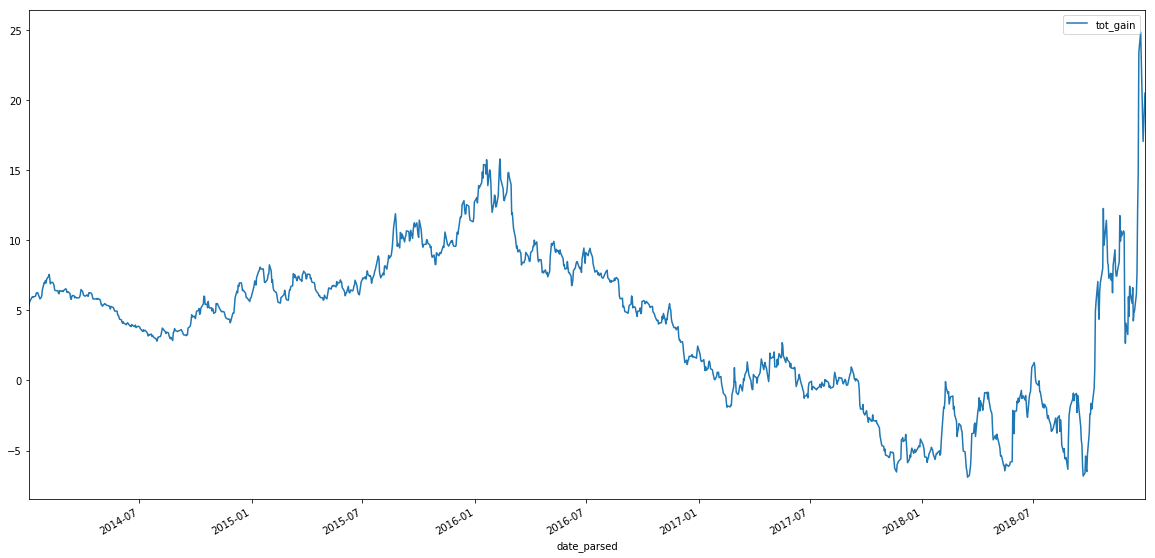

In [20]:

df['2014-01-01' : '2019-01-01'].plot(x = 'date_parsed', y ='tot_gain', figsize=(20,10))


**Plot of Price vs time**

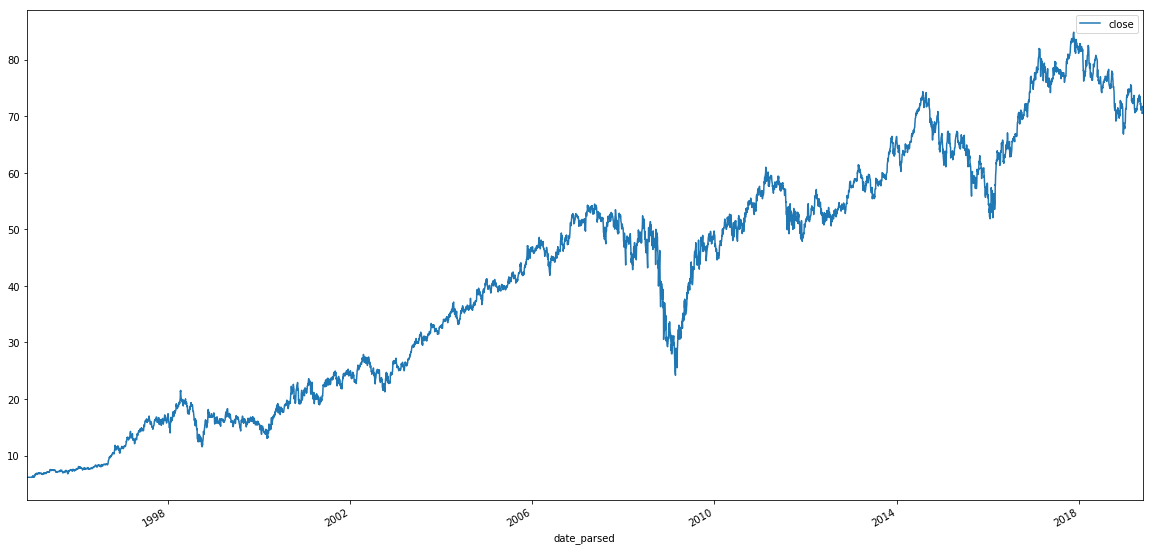

In [21]:
df.plot(x = 'date_parsed', y ='close', figsize=(20,10))

**Plot of price vs time, smoothed by 50-element Gaussian kernel**

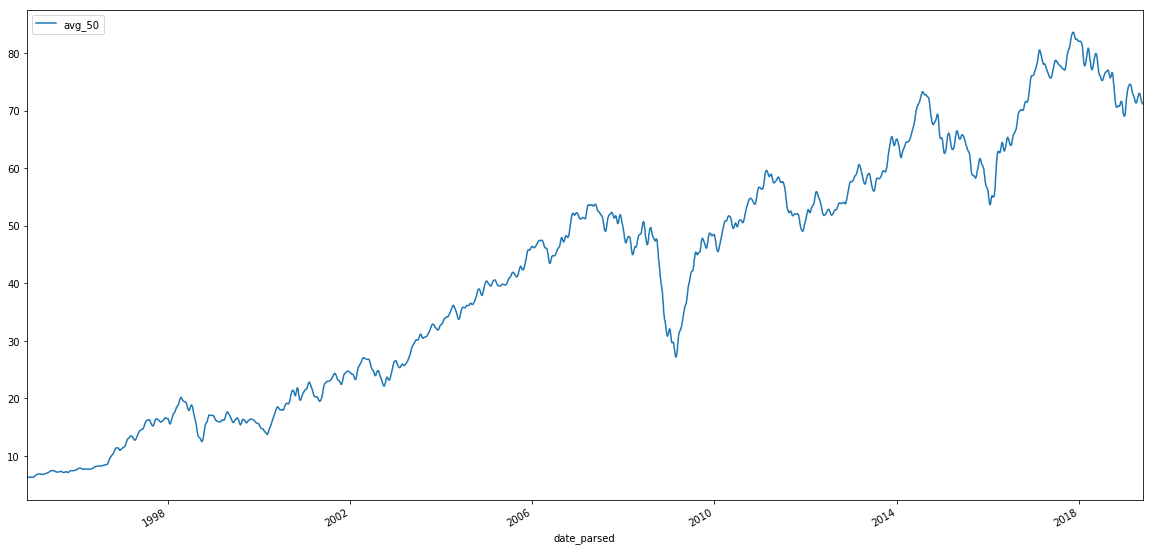

In [22]:
df.plot(x = 'date_parsed', y ='avg_50', figsize=(20,10))

**Plot of price vs time, smoothed by 200-element Gaussian kernel**

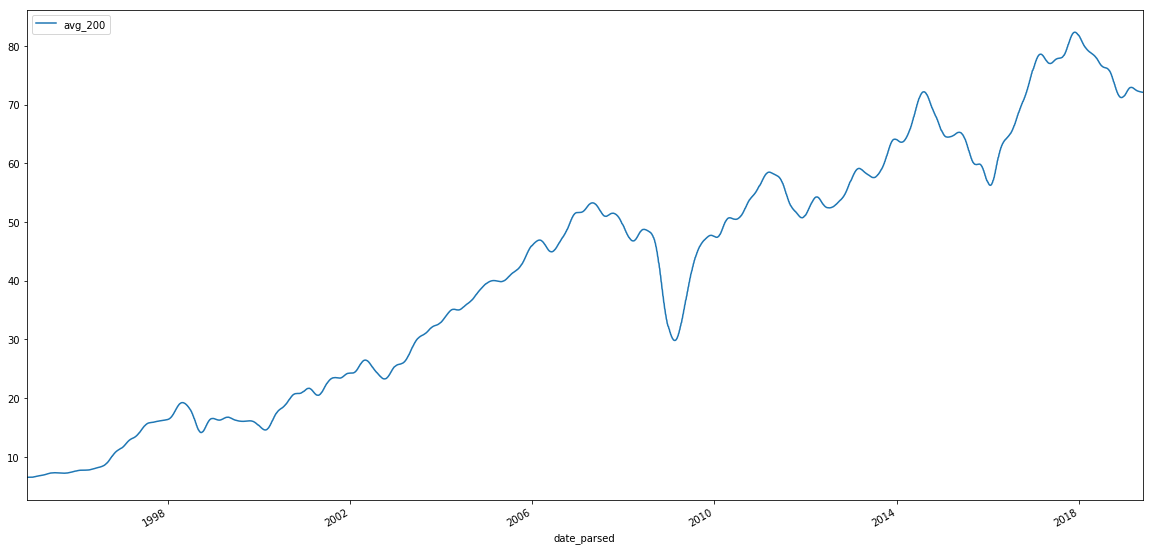

In [23]:
df.plot(x = 'date_parsed', y ='avg_200', figsize=(20,10))

The previous three plots illustrate how the Gaussian convolution suppress random noise in the price data, while preserving the peaks and dips quite effectively.

## Descriptive Statistics

This section explores the statistical properties of the valuation metrics, and of the historical returns given a specific valuation metric.  

The goal is to determine if these values are "well behaved" (i.e. predictable).

1.  Distribution of p-e metric
2.  Distribution of yield metric
3.  Distibution of return, given a p-e value +/- 5% 
4.  Distribution of return, given a yield value +/- 5%

### Distribution of Historic Price-to-Earnings values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b4139da58>]],
      dtype=object)

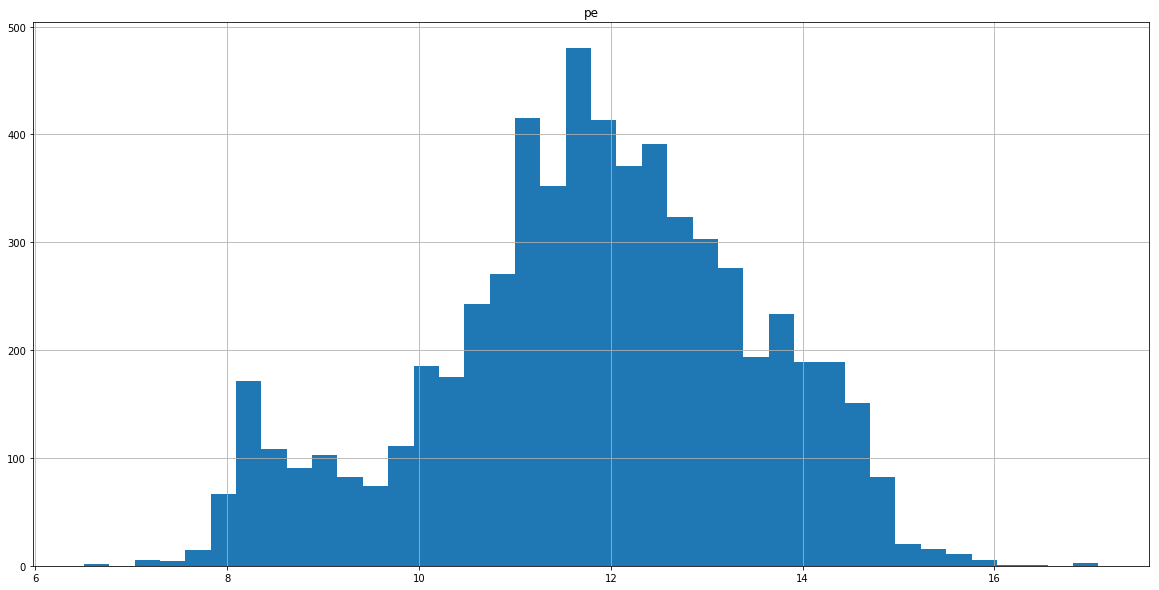

In [24]:
df.hist(['pe'], bins=40, figsize=(20,10))


#### Price-to-earnings metric vs. time
The dot-com era and 2008 financial crisis can be seen!

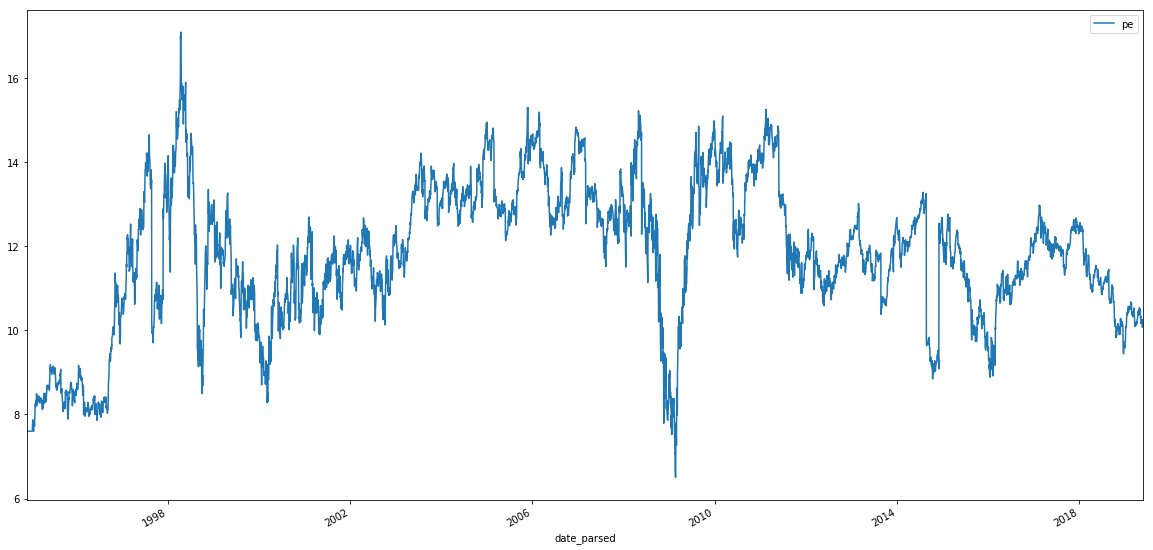

In [25]:
df.plot(x = 'date_parsed', y ='pe', figsize=(20,10))

### Distribution of historic dividend yield data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b41231518>]],
      dtype=object)

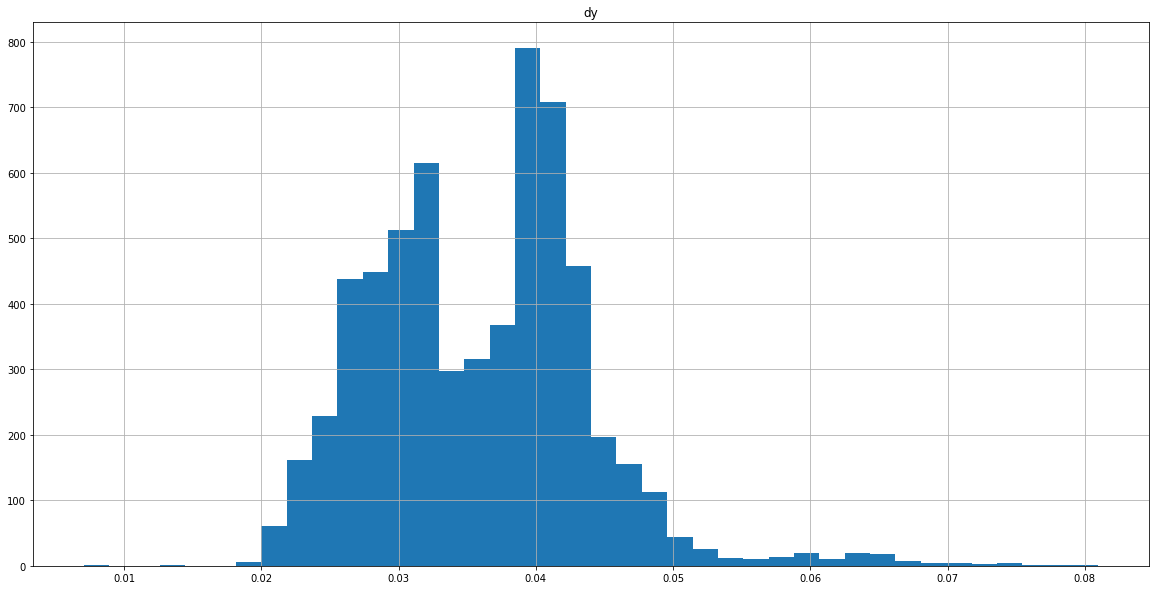

In [26]:
df.hist(['dy'], bins=40, figsize=(20,10))

**Dividend Yield vs time**

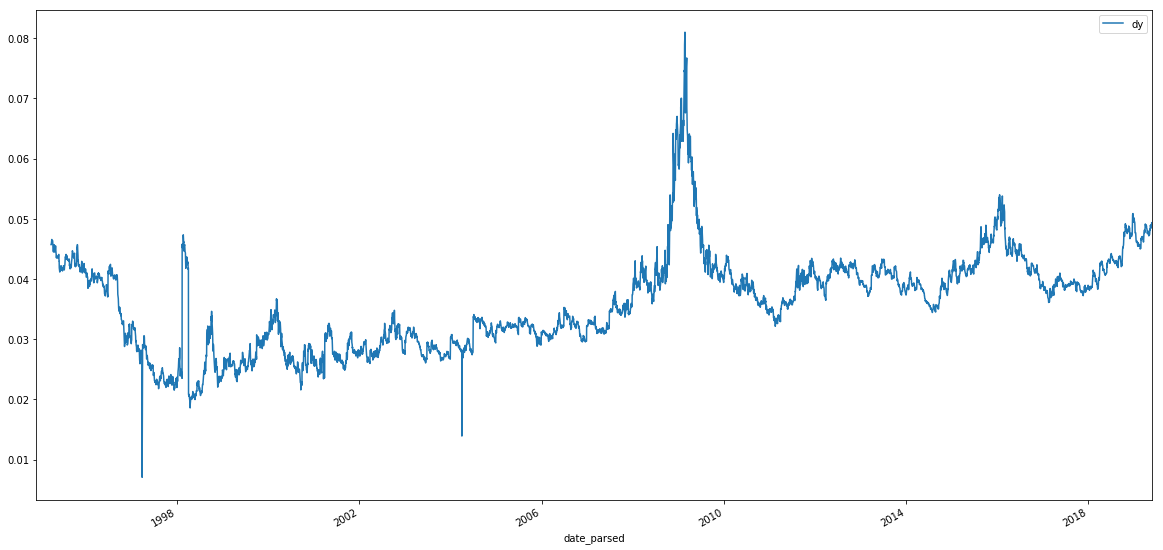

In [27]:
df.plot(x = 'date_parsed', y ='dy', figsize=(20,10))

In [28]:
df['dy'].mean()

0.03599270684109839

In [29]:
df['dy'].std()

0.007959282045283239

In [30]:
df['pe'].mean()

11.7966882652621

In [31]:
df['pe'].std()

1.684465859620857

#### Observation:
Both the dividend yield and p-e ratio are statistically well behaved -- their distribution follows something approaching a normal distribution, and just as importantly, the variance is small. 
    

### Expected gain given a P-E value or a Dividend Yield

Using recent values of 10.3 and 4.9% respectively, I generated a plot of long-term gains observed given a narrow range of P-E and yield possibilities.  The distribution follows  a roughtly Gaussian distribution.  This lends credibility to the idea that the gain is dependent on the observed P-E.

The values of gain given dividend yield were flatter, but still represented a range of values which were plausible.  Furthermore, the expected gain fell within the same range of values given both metrics.


10.514934273242131

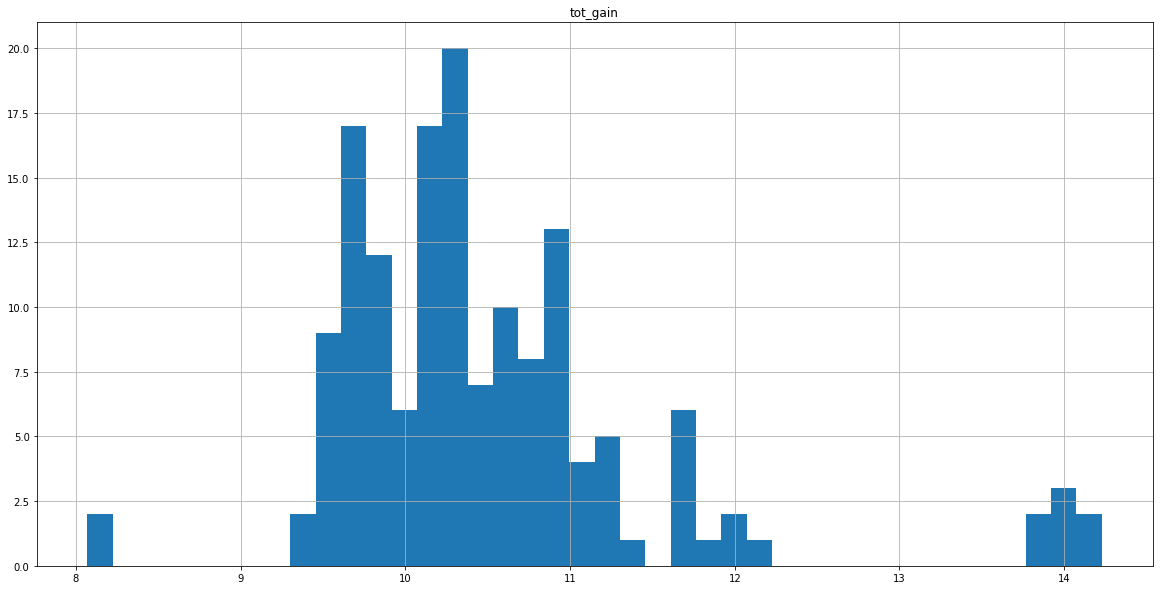

In [32]:
#10.45-10.15
df[(df['pe'] < 10.45) & (df['pe'] > 10.15) & (df['date_parsed'] < '2017-06-06')].hist(['tot_gain'], bins=40, figsize=(20,10))
df[(df['pe'] < 10.45) & (df['pe'] > 10.15) & (df['date_parsed'] < '2017-06-06')]['tot_gain'].mean()

11.828501208940448

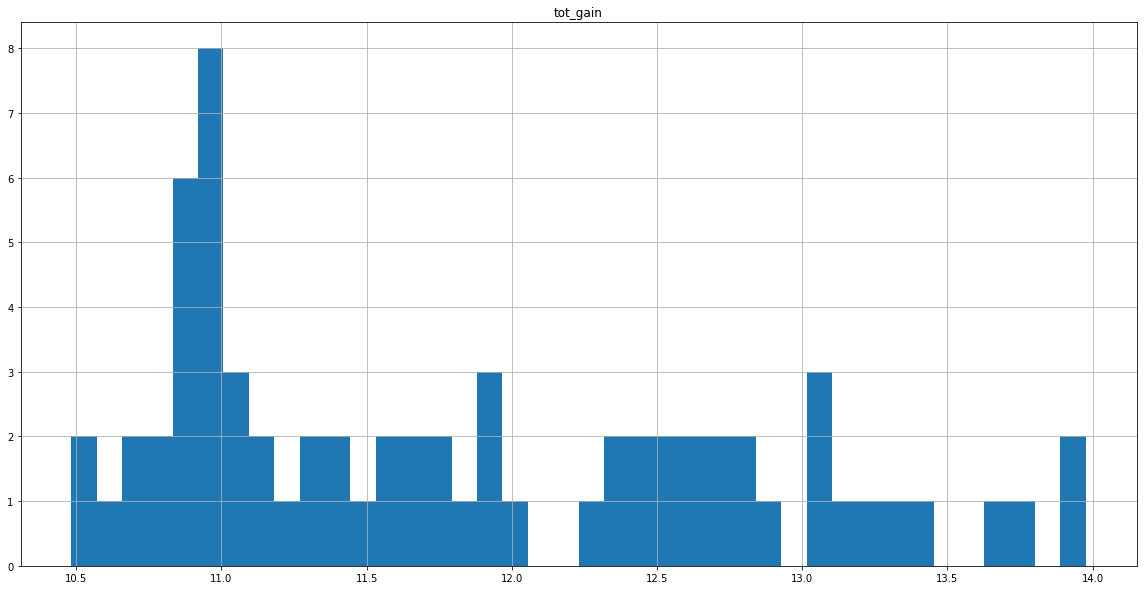

In [33]:
df[(df['dy'] < 0.0514) & (df['dy'] > 0.0484) & (df['date_parsed'] < '2017-06-06')].hist(['tot_gain'], bins=40, figsize=(20,10))
df[(df['dy'] < 0.0514) & (df['dy'] > 0.0484) & (df['date_parsed'] < '2017-06-06')]['tot_gain'].mean()

## Modelling - Part 2: Machine Learning

I used the LinearRegression class from the scikit-learn library to implement a machine learning solution.  I used a train-test split on the data, and recorded the $R^2$ scores for the regression learners using k-fold cross-validation.

This process was repeated for all constituents of the S&P/TSX Composite index.  For companies paying a dividend, I evaluated regression learners for X = [pe], X = [yield], and X = [pe | yield].  Since not all companies pay a dividend, non dividend companies were analyzed on the X = [pe] only.

Arbitrarily-selected findings are as follows:

| Symbol        | Name           | Learner  | Average $R^2$ | Sector | Industry |
| ------------- |:-------------|:-----:|-----:|:-----:|:-----:|
|CHR|Chorus Aviation Inc.|	multiple|		0.996401|	Industrials|	Airlines|
|ECN|ECN Capital Corp.|	p-e|	0.989879|	Financial Services|	Credit Services|
|CPX|Capital Power Corporation|	multiple|	0.949973|	Utilities|	Regulated Utilities|
|MIC|Genworth MI Canada Inc.|	multiple|		0.902307|	Financial Services|	Insurance - Specialty|
|IFC|Intact Financial Corporation|	multiple|		0.876099|	Financial Services|	Insurance - Property & |Casualty|
|SLF |Sun Life Financial Inc.|	multiple|		0.848432|	Financial Services|	Insurance|
|RY|Royal Bank of Canada|	multiple|		0.823604|	Financial Services|	Banks|
|CSU|Constellation Software Inc.|	multiple|		0.815943|	Technology|	Application Software|
|DOL|Dollarama Inc.|	multiple|		0.809595|	Consumer Cyclical|	Retail - Defensive|
|MTY|MTY Food Group Inc.|	multiple|		0.727087|	Consumer Cyclical|	Restaurants|
|TRP|TransCanada Corporation|	divs|		0.716312|	Energy|	Midstream|
|TD|Toronto-Dominion Bank|	multiple|		0.666686|	Financial Services|	Banks|
|CNR|Canadian National Railway Company|	multiple|		0.626448|	Industrials|	Transportation & Logistics|
|BCE|BCE Inc.|	divs|		0.595598|	Communication Services|	Communication Services|
|MG|Magna International Inc.|	divs|	0.572949|	Consumer Cyclical|	Autos|
|ONEX|Onex Corporation|	multiple|		0.462915|	Financial Services|	Conglomerates|
|QSR|Restaurant Brands International Inc.|	multiple|		0.417785|	Consumer Cyclical|	Restaurants|
|CAE|CAE Inc.|	multiple|	0.301199|	Industrials|	Aerospace & Defense|
|MFI|Maple Leaf Foods Inc.|	multiple|	0.267496|	Consumer Defensive|	Consumer Packaged Goods|
|OTEX|Open Text Corporation|	p-e	|0.173231|	Technology|	Application Software|
|SU|Suncor Energy Inc.|	multiple	|0.099518|	Energy|	Integrated Oil & Gas|
|WJA|WestJet Airlines Ltd.|	multiple|	0.024203|	Industrials|	Airlines|
|ERF|Enerplus Corporation|	multiple|	-0.004939|	Energy|	Exploration & Production|




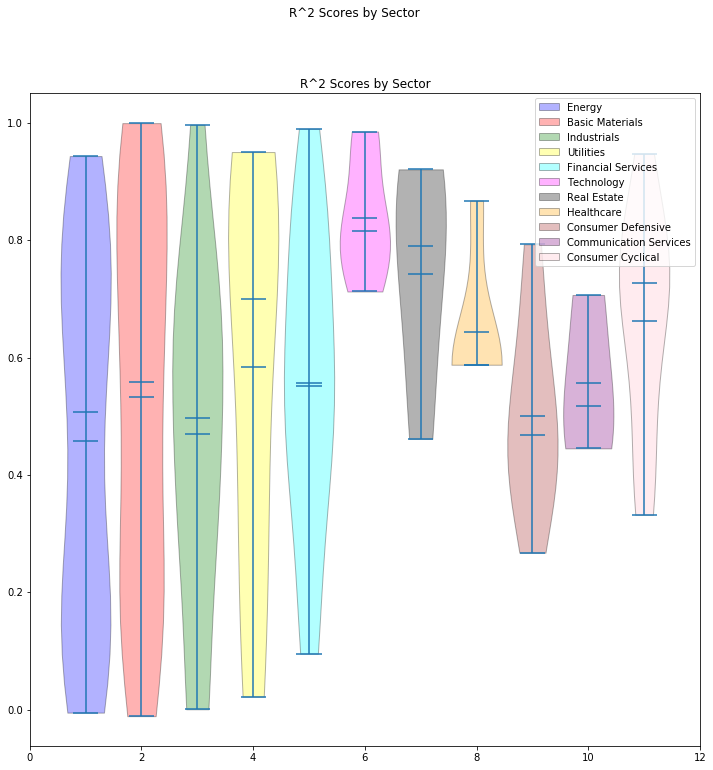

In [63]:
metrics_sql = 'SELECT * FROM regression_metrics JOIN tsx_companies on regression_metrics.symbol = tsx_companies.company_ticker WHERE method = "multiple"'
df_metrics = pd.read_sql_query(metrics_sql, advfn_database)

df_metrics['avg'] = (df_metrics['fold_1'] + df_metrics['fold_2'] + df_metrics['fold_3']) / 3.0

sect = ['Energy', 'Basic Materials', 'Industrials', 'Utilities',
       'Financial Services', 'Technology', 'Real Estate', 'Healthcare',
       'Consumer Defensive', 'Communication Services',
       'Consumer Cyclical']
label = sect
colors = ['b', 'r', 'g', 'yellow', 'cyan', 'magenta', 'black', 'orange', 'brown', 'purple', 'pink']

data = [df_metrics[(df_metrics['sector'] == s) & (df_metrics['avg'] > -0.2)]['avg'].values for s in sect]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

vio_plot = axes.violinplot(data, points=20, widths=0.9, showmeans=True, showextrema=True, showmedians=True)

for index, vplt in enumerate(vio_plot['bodies']):
    vplt.set_facecolor('black')
    vplt.set_facecolor(colors[index])
    vplt.set_edgecolor('black')

axes.set_title('R^2 Scores by Sector')

axes.legend(label)

fig.suptitle('R^2 Scores by Sector')
fig.subplots_adjust(hspace=0.4)
plt.show()


### Observation:
The R^2 scores represented a full range from less than 0 up to 1.  Encouragingly, the multiple regression learner outperformed the single learners in almost all cases, and in some cases dramatically.
For example:

| Symbol        | Name           | Learner  | Average $R^2$ | Sector | Industry |
| ------------- |:-------------|:-----:|-----:|:-----:|:-----:|
|BCE|	BCE Inc.|	multiple|	0.706504|	Communication Services	|Communication Services|
|BCE|	BCE Inc.|	divs	|	0.595598|	Communication Services	|Communication Services|
|BCE|	BCE Inc.|	p-e|		0.179536|	Communication Services|	Communication Services|

    

## Model Evaluation

### Descriptive Statistics

The ability of the statistical model to predict long-term returns will be limited by the variance of the data set, as expressed by the standard deviation.  This applies both to the parameters being used to predict the values (yield and p-e ratio), as well as the quantity being predicted (gain).

I have implemented a simple screen, where any equity where $$\dfrac{\sigma}{\mu} \gt k$$ of yield, p-e, or return, is excluded, for some threshold k.  This corresponds to the volatility risk, or $\beta$, which traders commonly use.

### Machine Learning

I have considered two screens for the machine learning predictions - first, do the returns predicted by both p-e regression and yield regression roughly match? (Within some tolerance).  If the separate predictions are widely different, I will not consider the model to bve useful.  The seconf is the $R^2$ metric.  Equities where $R^2 \lt 0.4$ are removed from consideration as the regression does a poor job of explaining the variability.


## Results and Conclusion

After applying the five screens described above, some businesses are in fact measureably more predicatable than otehrs, based on fundamental metrics.  

| Symbol        | Name           |Sector | Industry | Predicted Return  | $R^2$ Score | 
| ------------- |:-------------|:-----:|-----:|:-----:|:-----:
|CNR	|	Canadian National Railway Company	|	Industrials	|	Transportation & Logistics	|	16.3555540482	|	0.6264478494|
|CP	|	Canadian Pacific Railway Limited	|	Industrials	|	Transportation & Logistics	|	15.6118029116	|	0.6220643797|
|MTY	|	MTY Food Group Inc.	|	Consumer Cyclical	|	Restaurants	|	14.518074064	|	0.7270871798|
|TD	|	Toronto-Dominion Bank	|	Financial Services	|	Banks	|	13.1266208387	|	0.6666863479|
|NA	|	National Bank of Canada	|	Financial Services	|	Banks	|	12.8339438705	|	0.5073605154|
|X	|	TMX Group Limited	|	Financial Services	|	Brokers & Exchanges	|	12.5105037601	|	0.534817795|
|RY	|	Royal Bank of Canada	|	Financial Services	|	Banks	|	12.5061690387	|	0.8236041807|
|TRP	|	TransCanada Corporation	|	Energy	|	Midstream	|	12.1552453984	|	0.7336443069|
|MIC	|	Genworth MI Canada Inc.	|	Financial Services	|	Insurance - Specialty	|	11.5723276184	|	0.9023067373|
|BMO	|	Bank of Montreal	|	Financial Services	|	Banks	|	11.0255133935	|	0.7122934258|
|FTS	|	Fortis Inc.	|	Utilities	|	Regulated Utilities	|	10.5489883287	|	0.7945963242|


A second tier of equities where either expected return was less than 9%, or one of the three $\sigma$ screens was not met is:

| Symbol        | Name           |Sector | Industry | Predicted Return  | $R^2$ Score | 
| ------------- |:-------------|:-----:|-----:|:-----:|:-----:
|	FSV	|	FirstService Corporation	|	Real Estate	|	Real Estate Services	|	26.0510823247	|	26.0510823247	|
|	PBH	|	Premium Brands Holdings Corporation	|	Consumer Defensive	|	Consumer Packaged Goods	|	19.1197499152	|	19.1197499152	|
|	WSP	|	WSP Global Inc.	|	Industrials	|	Engineering & Construction	|	18.9536746931	|	18.9536746931	|
|	RBA	|	Ritchie Bros. Auctioneers Incorporated	|	Industrials	|	Business Services	|	13.9867720212	|	13.9867720212	|
|	T	|	Telus Corporation	|	Communication Services	|	Communication Services	|	12.7224706246	|	12.7224706246	|
|	CPX	|	Capital Power Corporation	|	Utilities	|	Regulated Utilities	|	11.8354164092	|	11.8354164092	|
|	IFC	|	Intact Financial Corporation	|	Financial Services	|	Insurance - Property & Casualty	|	11.4828938237	|	11.4828938237	|
|	MRU	|	Metro Inc.	|	Consumer Defensive	|	Retail - Defensive	|	10.7644573276	|	10.7644573276	|
|	CM	|	Canadian Imperial Bank of Commerce	|	Financial Services	|	Banks	|	9.647458084	|	9.647458084	|
|	IAG	|	Industrial Alliance Insurance and Financial Services Inc.	|	Financial Services	|	Insurance	|	9.4291614928	|	9.4291614928	|
|	BNS	|	Bank of Nova Scotia	|	Financial Services	|	Banks	|	8.6904993829	|	8.6904993829	|


It is notable that the sectors Telecom, Utilities, Real Estate, Railways, and Financials are heavily represented in the final list of value equities.  Thses sectors are traditionally targeted by value and dividend investors.  Their presence gives some validation to the model.

In conclusion:
Analysis of historical earnings, dividends, and price data for the TSX/S&P Composite Index constituents shows that a subset of the index can be predicted with confidence to provide a long-term return greater than 9%, and are therefore suitable candidates for a dividend-value investing style.


## Appendix
### Data acquisition scripts - Yahoo Finance


In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

#database libraries
import sqlite3
from sqlite3 import Error

import re
import time
import datetime

sqlite_db = '/home/ian/Data/advfn.db'
yahoo_db =  '/home/ian/Data/yahoo.db'
database = sqlite3.connect(sqlite_db)
yahoo_database = sqlite3.connect(yahoo_db)
curs = database.cursor()
yahoo_curs = yahoo_database.cursor()

def get_yahoo_indicators(symbol):
    '''
    Gets p-e, eps, div and yield, beta from yahoo finance for a symbol
    and writes to the yahoo database
    '''
    print('Data for {0}.TO'.format(symbol))

    url = 'https://finance.yahoo.com/quote/{0}.TO/'.format(symbol)
    resp = requests.get(url)
    page = resp.text 

    soup = BeautifulSoup(page, 'html.parser')   
    
    #split the div and yeild string which is formatted 'xx.xx (yy.yy%)'
    div_raw = soup.find('td', attrs={'data-test': 'DIVIDEND_AND_YIELD-value'})
    if div_raw is None:
        return
    else:
        dy = div_raw.string.split()
        if dy[0].strip() == 'N/A':
            div = 0
            div_yld = 0
        else:
            div = float(dy[0].strip().replace(',',''))
            div_yld = float(re.sub(r'[^\w.]', '', dy[1]))
    
    eps_raw = soup.find('td', attrs={'data-test': 'EPS_RATIO-value'}).string.strip()
    if eps_raw == 'N/A':
        eps = 0
    else:
        eps = float(eps_raw.replace(',',''))

    pe_raw = soup.find('td', attrs={'data-test': 'PE_RATIO-value'}).string.strip()
    if pe_raw == 'N/A':
        pe = 0
    else:
        pe = float(pe_raw.replace(',',''))

    beta_raw = soup.find('td', attrs={'data-test': 'BETA_3Y-value'}).string.strip()
    if beta_raw == 'N/A':
        beta = 0
    else:
        beta = float(beta_raw.replace(',',''))   
 
    
    date_today = str(datetime.date.today())
    #one time only to run on weekend
    #date_today = '2019-05-03'


    print('  eps          {}'.format(eps))
    print('  p-e          {}'.format(pe))
    print('  div paid     {}'.format(div))
    print('  div yield    {}'.format(div_yld))
    print('  beta         {}'.format(beta))
    #print('  earn date    {}'.format(earnings_date))
    print('\n')
    
    yahoo_sql = '''INSERT OR IGNORE INTO yahoo_indicators(symbol, Date, pe, eps, div_payout, div_yield, beta) VALUES(?,?,?,?,?,?,?)'''
    job = (symbol, date_today, pe, eps, div, div_yld, beta)
    yahoo_curs.execute(yahoo_sql, job)
    yahoo_database.commit()

def main():

    #get the symbols from the database
    curs.execute("select company_ticker from tsx_companies;")
    results = curs.fetchall()

    tickers = []

    '''Yahoo encodes income trusts with a hyphen
       Google uses a dot
       need to change AP.UN to AP-UN
    '''

    for res in results:
        symbol = res[0].replace('.','-')
        tickers.append(symbol)

    for symbol in tickers:
        get_yahoo_indicators(symbol)

if __name__ == '__main__':
    #main()

### Data Acquisition Scripts - Alphavantage (free API key)

In [ ]:


import requests
import pandas as pd
import sqlite3
import json
from sqlite3 import Error
import sqlalchemy
from sqlalchemy import create_engine
import time


api_key = 'PLEASE USE YOUR OWN KEY - Thanks'
sqlite_db = '/home/ian/Data/yahoo.db'
database = sqlite3.connect(sqlite_db)
curs = database.cursor()

#################
## Gets the daily time series data in JSON format from alphavantage for the symbol selected
##  In: the ticker symbol in Yahoo notation (no exchange)
##  Out: Writes time sereis to SQLite database
def get_daily_data(sym):
    #alphavantage uses a '-' to separate share classes or designate a unit, yahoo uses a '.'
    symbol = sym.replace('.','-')
    url_to_get = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}.TO&apikey=CTECN021MT4UQAJ2'.format(symbol)
    resp = requests.get(url_to_get)
    json_data = resp.text 
    time_ser_data = json.loads(json_data)

    #for valid response
    if 'Time Series (Daily)' in time_ser_data:
        df = pd.DataFrame.from_dict(time_ser_data['Time Series (Daily)']).T
        df['symbol'] = symbol
        df['Date'] = df.index
        df['Adj Close'] = ''
        df.columns = ['Open','High', 'Low','Close','Volume', 'symbol','Date', 'Adj Close']
        
        for index, row in df.iterrows():
            sql = '''INSERT OR IGNORE INTO aav_prices(symbol, Date) VALUES (?, ?)'''
            job = (symbol, row['Date'])
            #print(sql + str(job))
            curs.execute(sql, job)
            database.commit()

            sql = '''UPDATE aav_prices SET Open = ?, High = ?, Low = ?, Close = ?, Volume = ? WHERE symbol = ? AND Date = ?'''
            job = (row['Open'], row['High'], row['Low'], row['Close'], row['Volume'], symbol, row['Date'])
            curs.execute(sql, job)
            database.commit()



def main():

    #get the symbols and max index from the database
    engine = create_engine('sqlite:////home/ian/Data/advfn.db')
    symbol_df = pd.read_sql_table('tsx_companies', engine)

    for index, symbol in enumerate(symbol_df['company_ticker']):
        #Need to sleep for a minute after five scrapes - API rules
        if index %5 == 0:
            print('(need to wait 1 minute)')
            time.sleep(60)
        print('Scrape : {}'.format(symbol))
        get_daily_data(symbol)
        print('  .. done!')

if __name__ == '__main__':
    #main()

### Data Acquisition Scripts -- TMX Money

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import datetime
import re


#database libraries
import sqlite3
from sqlite3 import Error
import sqlalchemy
from sqlalchemy import create_engine

#Database Connection
tmx_db = '/home/ian/Data/tmx.db'
tmx_database = sqlite3.connect(tmx_db)
tmx_curs = tmx_database.cursor()

advfn_db = '/home/ian/Data/advfn.db'
advfn_database = sqlite3.connect(advfn_db)
advfn_curs = advfn_database.cursor()


def scrape_tmx(symbol):
	url = 'https://web.tmxmoney.com/earnings.php?qm_symbol={0}'.format(symbol)
	
	#get the page from the URL
	resp = requests.get(url)
	page = resp.text 
	
	#parse the HTML using Beautiful Soup
	soup = BeautifulSoup(page, 'html.parser')

	#inspect the rows of the table 'earningstable'
	table = soup.find('div', attrs = {'class': 'earningstable'})

	if table is None:
		print('No data for {0}'.format(symbol))
		return

	rows = table.findChildren('td')
	
	#columns are not named, so count off every five table divisions
	for index, val in enumerate(rows):
		col_num = index%5
		
		if col_num == 0:
			pass
		elif col_num == 1:
			parsed_date = datetime.datetime.strptime(val.text.strip(), '%m/%d/%y').strftime("%Y-%m-%d")  
			print('Data for {0} -- {1}'.format(symbol, parsed_date))

		elif col_num == 2:
			if val.text.strip() == '--':
				eps = 0.0
			else:
				eps = float(val.text.strip())
			print('  eps          {0}'.format(str(eps)))

		elif col_num == 3:
			consensus_raw = val.text.strip()
			#missing data encoded as '--'
			if consensus_raw == '--':
				consensus = 0.0
			else:
				consensus = float(consensus_raw)
			print('  consensus    {0}'.format(str(consensus)))

		else:
			surprise_raw = val.text.strip().split()
			#missing data encoded as '-- (--)'
			if surprise_raw[1] == '(--)':
				surprise = 0.0
			else:
				#surprise encoded as 'nn (nn.nn%)'
				#storing percent since this is earnings-independent
				surprise = float(re.sub(r'[^\w.-]', '', surprise_raw[1]))
			print('  surprise     {0}'.format(str(surprise)))			

			sql = '''INSERT OR IGNORE INTO tmx_earnings(symbol, date, eps, consensus_eps, surprise) VALUES(?,?,?,?,?)'''
			job =  (symbol, parsed_date, eps, consensus, surprise)
			tmx_curs.execute(sql, job)        
	
	print('\n')
	tmx_database.commit()
    
def main():

    #get the symbols from the database
    advfn_curs.execute("select company_ticker from tsx_companies;")
    results = advfn_curs.fetchall()

    tickers = []

	#tmx uses google nomenclature (BBD.B as opposed to BBD-B)
	#so the symbols in advfn are correct
    for res in results:
    	tickers.append(res[0])

    last_good = 'WN'
    have_data = True

    for symbol in tickers:
    	if symbol == last_good:
    		have_data = False
		
    	if not have_data:
        	scrape_tmx(symbol)

if __name__ == '__main__':
    #main()

### Machine learning R^2 Evaluation Script

In [ ]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib
import sys
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
#plt.figure(figsize=(20,10))

kern_200 = [0.000001,0.000001,0.000001,0.000001,0.000001,0.000002,0.000002,0.000002,0.000003,0.000003,0.000004,0.000005,0.000006,0.000007,0.000009,0.00001,0.000012,0.000015,0.000017,0.000021,0.000024,0.000029,0.000034,0.00004,0.000047,0.000054,0.000063,0.000074,0.000086,0.000099,0.000115,0.000133,0.000153,0.000176,0.000202,0.000231,0.000264,0.000301,0.000342,0.000388,0.00044,0.000498,0.000562,0.000632,0.000711,0.000797,0.000892,0.000996,0.00111,0.001235,0.001371,0.001519,0.001679,0.001852,0.002038,0.002239,0.002455,0.002686,0.002932,0.003194,0.003473,0.003769,0.00408,0.004409,0.004754,0.005116,0.005494,0.005888,0.006297,0.00672,0.007157,0.007607,0.008068,0.00854,0.00902,0.009508,0.010002,0.010499,0.010999,0.011498,0.011996,0.012489,0.012975,0.013453,0.013919,0.014372,0.014809,0.015228,0.015626,0.016002,0.016353,0.016677,0.016972,0.017237,0.01747,0.01767,0.017835,0.017964,0.018058,0.018114,0.018132,0.018114,0.018058,0.017964,0.017835,0.01767,0.01747,0.017237,0.016972,0.016677,0.016353,0.016002,0.015626,0.015228,0.014809,0.014372,0.013919,0.013453,0.012975,0.012489,0.011996,0.011498,0.010999,0.010499,0.010002,0.009508,0.00902,0.00854,0.008068,0.007607,0.007157,0.00672,0.006297,0.005888,0.005494,0.005116,0.004754,0.004409,0.00408,0.003769,0.003473,0.003194,0.002932,0.002686,0.002455,0.002239,0.002038,0.001852,0.001679,0.001519,0.001371,0.001235,0.00111,0.000996,0.000892,0.000797,0.000711,0.000632,0.000562,0.000498,0.00044,0.000388,0.000342,0.000301,0.000264,0.000231,0.000202,0.000176,0.000153,0.000133,0.000115,0.000099,0.000086,0.000074,0.000063,0.000054,0.000047,0.00004,0.000034,0.000029,0.000024,0.000021,0.000017,0.000015,0.000012,0.00001,0.000009,0.000007,0.000006,0.000005,0.000004,0.000003,0.000003,0.000002,0.000002,0.000002,0.000001,0.000001,0.000001,0.000001,0.000001]
kern_50 =  [0,0.000001,0.000002,0.000005,0.000012,0.000027,0.00006,0.000125,0.000251,0.000484,0.000898,0.001601,0.002743,0.004514,0.00714,0.010852,0.015849,0.022242,0.029993,0.038866,0.048394,0.057904,0.066574,0.073551,0.078084,0.079656,0.078084,0.073551,0.066574,0.057904,0.048394,0.038866,0.029993,0.022242,0.015849,0.010852,0.00714,0.004514,0.002743,0.001601,0.000898,0.000484,0.000251,0.000125,0.00006,0.000027,0.000012,0.000005,0.000002,0.000001,0]

yahoo_db = '/home/ian/Data/yahoo.db'
tmx_db = '/home/ian/Data/tmx.db'
advfn_db = '/home/ian/Data/advfn.db'

yahoo_database = sqlite3.connect(yahoo_db)
tmx_database = sqlite3.connect(tmx_db)
advfn_database = sqlite3.connect(advfn_db)
advfn_curs = advfn_database.cursor()

def process_row(row, df):
    if (row['close'] != row['close']) | (row['close'] == 'null'):
        df.at[row['date_parsed'], 'pe'] = np.NaN
        df.at[row['date_parsed'], 'dy'] = np.NaN
        return
    if row['eps'] == row['eps']:
        if row['eps'] == 0:
            df.at[row['date_parsed'], 'pe'] = np.NaN
        else:
            df.at[row['date_parsed'], 'pe'] = float(row['close']) / (4*row['eps'])
    
    if row['eps'] == row['eps']:
        if row['close'] == 0:
            df.at[row['date_parsed'], 'dy'] = np.NaN
        else:
            df.at[row['date_parsed'], 'dy'] = 4* row['div'] / (float(row['close']) * row['split_adj'])

def custom_kernel(func, kern):
    '''
    Convolution of a function by a kernel.
    Kernel must be odd in length
    Function must be longer than kernel    
    '''
    if len(func) < len(kern):
        return func
    else:
        #midpoint of the kernel
        mid_kern = int((len(kern) + 1)/2)
        
    conv_func = np.zeros(len(func))
    
    for index, value in enumerate(func):
        
        ##TODO: this case is backwards I think
        if index < mid_kern:
            #go from kern[mid_kern] to end for zero
            dist_from_start = index -1
            kern_start = mid_kern - dist_from_start         
           
            sum = 0.0
            area = 0.0
            for i in range(kern_start, len(kern)):                
                sum += kern[i] * func[index + i - mid_kern]
                #need to correct for the area under the partial kernel being < 1
                area += kern[i]
            conv_func[index] = sum / area
            
        elif index > len(func) - mid_kern:         
            #go from zero to mid_kern + (distance to end of func)
            dist_to_end = len(func) - index + 1
            sum = 0.0
            area = 0.0
            for i in range(0, (mid_kern + dist_to_end -1)):
                sum += kern[i] * func[index + i - mid_kern]
                area += kern[i]
            conv_func[index] = sum / area   
            
        else:
            #sum of kernel * function over window of kernel length centered on func[index]
            sum = 0.0
            for kern_ind, kern_val in enumerate(kern):
                sum += kern_val * func[index + kern_ind - mid_kern]
            conv_func[index] = sum
        
    return conv_func

def return_to_date(row, today, last_close):
    elapsed_years = (today - row['date_parsed']).days / 365.25
    if elapsed_years == 0:
        return 1.0
    gain = last_close / row['close']
    ann_gain = gain ** (1/elapsed_years)
    return 100 * (ann_gain - 1.0)

def prune_data(df, divs, num_sig):
    '''
    Removes outliers from the dataframe
    Removes num_sig-sigma
    '''

    if divs:
        pe_mean = np.mean(df['pe'])
        pe_std = np.std(df['pe'])
        div_mean = np.mean(df['dy'])
        div_std = np.std(df['dy'])
        gain_mean = np.mean(df['tot_gain'])
        gain_std = np.std(df['tot_gain'])
        pe_upper = pe_mean + num_sig * pe_std
        pe_lower = pe_mean - num_sig * pe_std
        div_upper = div_mean + num_sig * div_std
        div_lower = div_mean - num_sig * div_std
        gain_upper = gain_mean + num_sig * gain_std
        gain_lower = gain_mean - num_sig * gain_std

        df_pruned = df[(df['pe'] < pe_upper) & (df['pe'] > pe_lower) & (df['dy'] < div_upper) & (df['dy'] > div_lower) & (df['pe'] > 0) & (df['tot_gain'] < gain_upper) & (df['tot_gain'] > gain_lower)].copy()

    else:
        pe_mean = np.mean(df['pe'])
        pe_std = np.std(df['pe'])

        pe_upper = pe_mean + num_sig * pe_std
        pe_lower = pe_mean - num_sig * pe_std
        
        gain_mean = np.mean(df['tot_gain'])
        gain_std = np.std(df['tot_gain'])
        
        gain_upper = gain_mean + num_sig * gain_std
        gain_lower = gain_mean - num_sig * gain_std

        df_pruned = df[(df['pe'] < pe_upper) & (df['pe'] > pe_lower) & (df['pe'] > 0) & (df['tot_gain'] < gain_upper) & (df['tot_gain'] > gain_lower)].copy()

    return df_pruned

def show_regression(df, divs, symbol):
    '''
    Trains a regression learner for pe-total gain and yield-total gain
    K-folds the data and prints r_squared for each fold
    Plots the most recent fold
    Gain is used up to 2017-05-06
    '''

    #was 2018-05-06

    df_pruned = prune_data(df[:'2017-05-06'], divs, 3.0)

    if df_pruned.shape[0] < 3:
        print('Not enough data')
        return

    X = pd.DataFrame(df_pruned['pe'])
    y = pd.DataFrame(df_pruned['tot_gain'])

    X.fillna(value = 0, inplace = True)
    y.fillna(value = 0, inplace = True)

    model = LinearRegression()
    scores = []
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    for i, (train, test) in enumerate(kfold.split(X, y)):
        model.fit(X.iloc[train,:], y.iloc[train,:])
        score = model.score(X.iloc[test,:], y.iloc[test,:])
        scores.append(score)

    print('Rsquared for 3-fold p-e data:' + str(scores))
    y_pred = model.predict(X)

    sql_text = 'INSERT OR IGNORE INTO regression_metrics(symbol, method, fold_1, fold_2, fold_3) VALUES(?, ?, ?, ?, ?)'
    job = (symbol, 'p-e', scores[0], scores[1], scores[2])
    advfn_curs.execute(sql_text, job)
    advfn_database.commit()

    if divs:
        X = pd.DataFrame(df_pruned['dy'])
        y = pd.DataFrame(df_pruned['tot_gain'])

        X.fillna(value = 0, inplace = True)
        y.fillna(value = 0, inplace = True)

        model2 = LinearRegression()
        scores2 = []
        kfold2 = KFold(n_splits=3, shuffle=True, random_state=42)
        for i, (train, test) in enumerate(kfold2.split(X, y)):
            model2.fit(X.iloc[train,:], y.iloc[train,:])
            score2 = model2.score(X.iloc[test,:], y.iloc[test,:])
            scores2.append(score2)

        print('Rsquared for 3-fold div data:' + str(scores2))

        sql_text = 'INSERT OR IGNORE INTO regression_metrics(symbol, method, fold_1, fold_2, fold_3) VALUES(?, ?, ?, ?, ?)'
        job = (symbol, 'divs', scores2[0], scores2[1], scores2[2])
        advfn_curs.execute(sql_text, job)
        advfn_database.commit()

        y_pred2 = model2.predict(X)

def show_regression2(df, divs, symbol):
    '''
    Trains a regression learner for pe-total gain and yield-total gain
    K-folds the data and prints r_squared for each fold
    Plots the most recent fold
    Gain is used up to 2017-05-06
    '''

    #was 2018-05-06

    df_pruned = prune_data(df[:'2017-05-06'], divs, 3.0)

    if df_pruned.shape[0] < 3:
        print('Not enough data')
        return

    if not divs:

        X = pd.DataFrame(df_pruned['pe'])
        y = pd.DataFrame(df_pruned['tot_gain'])

        X.fillna(value = 0, inplace = True)
        y.fillna(value = 0, inplace = True)

        model = LinearRegression()
        scores = []
        kfold = KFold(n_splits=3, shuffle=True, random_state=42)
        for i, (train, test) in enumerate(kfold.split(X, y)):
            model.fit(X.iloc[train,:], y.iloc[train,:])
            score = model.score(X.iloc[test,:], y.iloc[test,:])
            scores.append(score)

        print('Rsquared for 3-fold p-e data:' + str(scores))
        y_pred = model.predict(X)

    else:
        X = pd.DataFrame(df_pruned[['pe', 'dy']])
        y = pd.DataFrame(df_pruned['tot_gain'])

        X.fillna(value = 0, inplace = True)
        y.fillna(value = 0, inplace = True)

        model2 = LinearRegression()
        scores2 = []
        kfold2 = KFold(n_splits=3, shuffle=True, random_state=42)
        for i, (train, test) in enumerate(kfold2.split(X, y)):
            model2.fit(X.iloc[train,:], y.iloc[train,:])
            score2 = model2.score(X.iloc[test,:], y.iloc[test,:])
            scores2.append(score2)

        print('Rsquared for 3-fold combined data:' + str(scores2))

        y_pred2 = model2.predict(X)

        sql_text = 'INSERT OR IGNORE INTO regression_metrics(symbol, method, fold_1, fold_2, fold_3) VALUES(?, ?, ?, ?, ?)'
        job = (symbol, 'multiple', scores2[0], scores2[1], scores2[2])
        advfn_curs.execute(sql_text, job)
        advfn_database.commit()

'''
advfn.db - uses google notation
tmx.db - uses google notation
yahoo.db 
    aav_prices uses yahoo notation
    divs uses yahoo notation
    splits uses yahoo notation
    tsx_prices uses google notation
    yahoo_indicators uses yahoo notation

'''

def main():
    if len(sys.argv) == 2:
        symbol = sys.argv[1]

        print('Generate data set for {0}'.format(symbol))
        print('   SQL queries...')

        #change this from yahoo to google notation
        tmx_sql = '''SELECT date, eps FROM tmx_earnings WHERE symbol = "{0}"'''.format(symbol.replace('-','.'))
        df_tmx = pd.read_sql_query(tmx_sql, tmx_database)
        df_tmx.columns = ['date', 'eps']
        df_tmx['date_parsed'] = df_tmx['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
        df_tmx.drop(columns = 'date', inplace = True)

        aav_sql = '''SELECT Date, Close FROM aav_prices WHERE symbol = "{0}" AND close != "null"'''.format(symbol)
        df_aav = pd.read_sql_query(aav_sql, yahoo_database)
        df_aav.columns = ['date', 'close']
        df_aav['date_parsed'] = df_aav['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
        df_aav.drop(columns = 'date', inplace = True)

        #need to change yahoo notation to google notation
        yahoo_prices_sql = '''SELECT Date, Close FROM tsx_prices WHERE symbol = "{0}" AND close != "null"'''.format(symbol.replace('-','.'))
        df_y_price = pd.read_sql_query(yahoo_prices_sql, yahoo_database)
        df_y_price.columns = ['date', 'close']
        df_y_price['date_parsed'] = df_y_price['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
        df_y_price.drop(columns = 'date', inplace = True)

        divs_sql = '''SELECT Date, Dividends FROM divs WHERE symbol = "{0}"'''.format(symbol)
        df_divs = pd.read_sql_query(divs_sql, yahoo_database) 
        df_divs.columns = ['date', 'div']
        df_divs['date_parsed'] = df_divs['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
        df_divs.drop(columns = 'date', inplace = True)

        df_price = pd.concat([df_y_price, df_aav])
        print('Before: ' + str(df_price.shape[0]))
        df_price.drop_duplicates(subset='date_parsed', inplace = True)
        print('After: ' + str(df_price.shape[0]))
        df_price

        split_sql = '''SELECT date, total_adjustment FROM splits WHERE symbol = "{0}"'''.format(symbol)
        df_split = pd.read_sql_query(split_sql, yahoo_database) 
        df_split.columns = ['date', 'split_adj']
        df_split['date_parsed'] = df_split['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
        df_split.drop(columns = 'date', inplace = True)

        print('   complete!')

        print('   Merge dataframes...')
        df = df_price.join(df_tmx.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)

        df = df.join(df_divs.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)

        df.fillna(method='ffill', inplace = True)

        df = df.join(df_split.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)
        df.set_index(df['date_parsed'], inplace= True)

        #split adjustment for current date is 1.0 -- backfill missing values

        df.iloc[-1, df.columns.get_loc('split_adj')] = 1.0
        df['split_adj'].fillna(method='bfill', inplace = True)
        df.tail(5)

        #this is for current quarter only - go back and fill the TTM on df_earnings and df_divs
        df['pe'] = 0.0
        df['dy'] = 0.0

        print('   complete!')
        print('   Calculate yield and eps...')
            
            
        df['close'].fillna(method = 'bfill', inplace = True)
        df.apply((lambda x: process_row(x, df)), axis = 1)

        print('   complete!')
        print('   Calculate returns...')

        df['avg_50'] = custom_kernel(df['close'], kern_50)
        df['avg_200'] = custom_kernel(df['close'], kern_200)

        today = datetime.datetime.today()
        last_close = df.tail(1)['avg_200'][0]

        df['cap_gain'] = df.apply(lambda x: return_to_date(x, today, last_close), axis = 1) 
        if (df.tail(1)['dy'][0] > 0):
            divs = True
            print('Found a dividend yield')
            df['tot_gain'] = df['cap_gain'] + (df['dy'] * 100)
        else:
            divs = False
            print('No dividend yield found')
            df['tot_gain'] = df['cap_gain']

        print('  complete!')

        show_regression(df, divs, symbol)
        show_regression2(df, divs, symbol)    

    else:
        sql_symbols = 'SELECT company_ticker FROM tsx_companies'
        advfn_curs.execute(sql_symbols)
        res = advfn_curs.fetchall()
        symbols = []
        for sym in res:
            symbols.append(sym[0])
            symbol = sym[0]
            print('Generate data set for {0}'.format(symbol))
            print('   SQL queries...')

            #change this from yahoo to google notation
            tmx_sql = '''SELECT date, eps FROM tmx_earnings WHERE symbol = "{0}"'''.format(symbol.replace('-','.'))
            df_tmx = pd.read_sql_query(tmx_sql, tmx_database)
            df_tmx.columns = ['date', 'eps']
            df_tmx['date_parsed'] = df_tmx['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
            df_tmx.drop(columns = 'date', inplace = True)

            aav_sql = '''SELECT Date, Close FROM aav_prices WHERE symbol = "{0}" AND close != "null"'''.format(symbol)
            df_aav = pd.read_sql_query(aav_sql, yahoo_database)
            df_aav.columns = ['date', 'close']
            df_aav['date_parsed'] = df_aav['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
            df_aav.drop(columns = 'date', inplace = True)

            #need to change yahoo notation to google notation
            yahoo_prices_sql = '''SELECT Date, Close FROM tsx_prices WHERE symbol = "{0}" AND close != "null"'''.format(symbol.replace('-','.'))
            df_y_price = pd.read_sql_query(yahoo_prices_sql, yahoo_database)
            df_y_price.columns = ['date', 'close']
            df_y_price['date_parsed'] = df_y_price['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
            df_y_price.drop(columns = 'date', inplace = True)

            divs_sql = '''SELECT Date, Dividends FROM divs WHERE symbol = "{0}"'''.format(symbol)
            df_divs = pd.read_sql_query(divs_sql, yahoo_database) 
            df_divs.columns = ['date', 'div']
            df_divs['date_parsed'] = df_divs['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
            df_divs.drop(columns = 'date', inplace = True)

            df_price = pd.concat([df_y_price, df_aav])
            print('Before: ' + str(df_price.shape[0]))
            df_price.drop_duplicates(subset='date_parsed', inplace = True)
            print('After: ' + str(df_price.shape[0]))
            df_price

            split_sql = '''SELECT date, total_adjustment FROM splits WHERE symbol = "{0}"'''.format(symbol)
            df_split = pd.read_sql_query(split_sql, yahoo_database) 
            df_split.columns = ['date', 'split_adj']
            df_split['date_parsed'] = df_split['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
            df_split.drop(columns = 'date', inplace = True)

            print('   complete!')

            print('   Merge dataframes...')
            df = df_price.join(df_tmx.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)

            df = df.join(df_divs.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)

            df.fillna(method='ffill', inplace = True)

            df = df.join(df_split.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)
            df.set_index(df['date_parsed'], inplace= True)

            #split adjustment for current date is 1.0 -- backfill missing values

            df.iloc[-1, df.columns.get_loc('split_adj')] = 1.0
            df['split_adj'].fillna(method='bfill', inplace = True)
            df.tail(5)

            #this is for current quarter only - go back and fill the TTM on df_earnings and df_divs
            df['pe'] = 0.0
            df['dy'] = 0.0

            print('   complete!')
            print('   Calculate yield and eps...')
                
                
            df['close'].fillna(method = 'bfill', inplace = True)
            df.apply((lambda x: process_row(x, df)), axis = 1)

            print('   complete!')
            print('   Calculate returns...')

            df['avg_50'] = custom_kernel(df['close'], kern_50)
            df['avg_200'] = custom_kernel(df['close'], kern_200)

            today = datetime.datetime.today()
            last_close = df.tail(1)['avg_200'][0]

            #print('Elapsed: ' + str((today - df.head(1)['date_parsed'][0]).days / 365.25 ) + ' years')

            df['cap_gain'] = df.apply(lambda x: return_to_date(x, today, last_close), axis = 1) 
            if (df.tail(1)['dy'][0] > 0):
                divs = True
                print('Found a dividend yield')
                df['tot_gain'] = df['cap_gain'] + (df['dy'] * 100)
            else:
                divs = False
                print('No dividend yield found')
                df['tot_gain'] = df['cap_gain']

            print('  complete!')

            show_regression(df, divs, symbol)
            show_regression2(df, divs, symbol)



if __name__ == '__main__':
    #main()